In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
final_df = pd.read_csv("../create_datasets/final_out_of_possesion_df.csv")
team_ids = final_df['uniqueTeamId']

In [3]:
final_df.columns

Index(['uniqueTeamId', 'Air duel_Zone_1', 'Air duel_Zone_2', 'Air duel_Zone_3',
       'Foul_Zone_1', 'Foul_Zone_2', 'Foul_Zone_3',
       'Ground attacking duel_Zone_1', 'Ground attacking duel_Zone_2',
       'Ground attacking duel_Zone_3', 'Ground defending duel_Zone_1',
       'Ground defending duel_Zone_2', 'Ground defending duel_Zone_3',
       'Ground loose ball duel_Zone_1', 'Ground loose ball duel_Zone_2',
       'Ground loose ball duel_Zone_3', 'Touch_Zone_1', 'Touch_Zone_2',
       'Touch_Zone_3', 'Acceleration', 'Air duel', 'Clearance', 'Foul',
       'Goalkeeper leaving line', 'Ground attacking duel',
       'Ground defending duel', 'Ground loose ball duel', 'Hand foul',
       'Late card foul', 'Out of game foul', 'Protest', 'Simulation',
       'Time lost foul', 'Touch', 'Violent Foul', 'Zone_1_Run', 'Zone_2_Run',
       'Zone_3_Run', 'Backward Run', 'Forward Run', 'Side Run', 'Short Run',
       'Middle Run', 'Long Run', 'average_acceleration_length',
       'Forward_Run

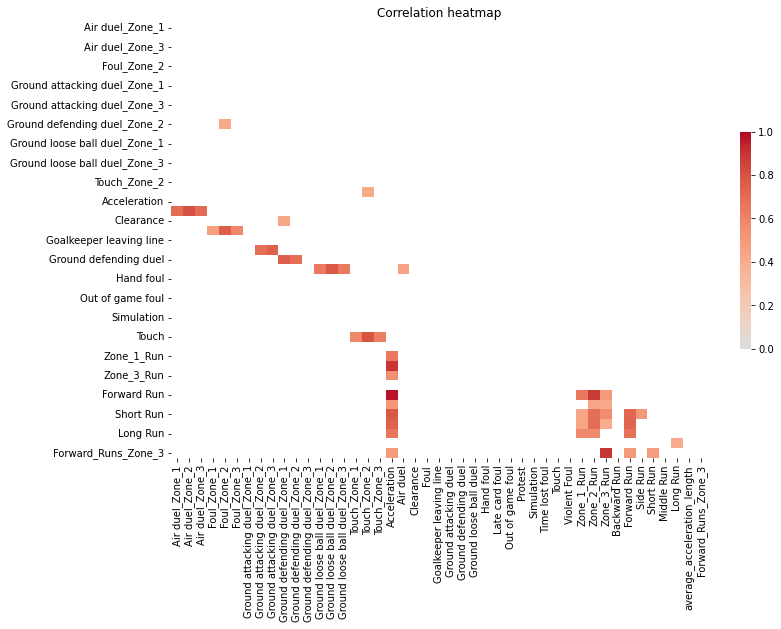

In [4]:
corr = final_df.drop(["uniqueTeamId"], axis = 1).corr().abs()
corr[corr.abs() < 0.4] = np.nan

plt.figure(figsize=(12, 8))
sns.heatmap(corr.abs(), cmap="coolwarm", 
            mask=np.triu(np.ones_like(corr.abs(), dtype=bool)),
            cbar_kws={"shrink": .5}, vmin=0, vmax=1, center= 0)
plt.title('Correlation heatmap')
plt.show()

In [5]:
final_df.set_index("uniqueTeamId", inplace = True)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from kmedoids import KMedoids
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer
from pyclustering.utils import calculate_distance_matrix
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

    # Autoencoder for DEC
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, z):
        return self.model(z)

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


    # DEC model
class DEC(nn.Module):
    def __init__(self, encoder, cluster_centers):
        super().__init__()
        self.encoder = encoder
        self.clusters = nn.Parameter(cluster_centers)

    def forward(self, x):
        z = self.encoder(x)
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.clusters)**2, dim=2))
        q = q / torch.sum(q, dim=1, keepdim=True)
        return q

# Target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()

In [9]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist

def compute_indices(X, labels):
    n_clusters = len(np.unique(labels))
    cluster_centers = []
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) == 0:
            cluster_centers.append(np.zeros(X.shape[1]))
        else:
            cluster_centers.append(cluster_points.mean(axis=0))
    cluster_centers = np.array(cluster_centers)

    distances = pairwise_distances(X, cluster_centers)

    # Iwcss: Sum of squared distances to cluster centers
    Iwcss = sum(np.sum((X[labels == i] - cluster_centers[i]) ** 2) for i in range(n_clusters))

    # Isep: Mean distance between all cluster centers
    Isep = np.mean(cdist(cluster_centers, cluster_centers))

    # Idistcc and Idens with filtering for valid clusters
    valid_dists = []
    valid_dens = []
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) < 2:
            continue  # Skip small clusters to avoid NaN in mean/std
        distances_to_center = np.linalg.norm(cluster_points - cluster_centers[i], axis=1)
        valid_dists.append(np.mean(distances_to_center))
        valid_dens.append(np.std(distances_to_center))

    # Default to 0 if all clusters were invalid
    Idistcc = np.mean(valid_dists) if valid_dists else 0.0
    Idens = np.mean(valid_dens) if valid_dens else 0.0

    return Iwcss, Isep, Idistcc, Idens



def normalize(val, min_val, max_val, larger_is_better):
    range_ = max_val - min_val
    if np.isclose(range_, 0):
        return 1.0  # or 0.5, depending on how you want to treat flat metrics
    if larger_is_better:
        return np.clip((val - min_val) / (range_ + 1e-10), 0, 1)
    else:
        return np.clip(1 - (val - min_val) / (range_ + 1e-10), 0, 1)

In [13]:
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# If using GPU
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

scaler = StandardScaler()
X_scaled = scaler.fit_transform(final_df)

pca2 = PCA(n_components=2)
X_pca = pca2.fit_transform(X_scaled)

# Tensor version for PyTorch
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# Store results
results = []

dec_loss = {}

# Iterate over k values
for k in range(2, 11):
    dec_loss[k] = {'ae_loss' : [], 'kl_loss' : []}
    clusterings = {
        'kmeans': KMeans(n_clusters=k, random_state=42),
        'kmedoids': KMedoids(n_clusters=k, metric='euclidean', init='random', max_iter=300, random_state=42),
        'ward': AgglomerativeClustering(n_clusters=k, linkage='ward')
    }

    for method_name, model in clusterings.items():
        labels = model.fit_predict(X_scaled)
        sil_score = silhouette_score(X_scaled, labels)
        
        Iwcss, Isep, Idistcc, Idens = compute_indices(X_scaled, labels)

        results.append({
            'k': k,
            'method': method_name,
            'silhouette_score': sil_score,
            'Iwcss': Iwcss,
            'Isep': Isep,
            'Idistcc': Idistcc,
            'Idens': Idens
        })
        
        print(results[-1])
        
        
    for method_name, model in clusterings.items():
        labels = model.fit_predict(X_pca)
        sil_score = silhouette_score(X_pca, labels)
        
        Iwcss, Isep, Idistcc, Idens = compute_indices(X_pca, labels)

        results.append({
            'k': k,
            'method': f"{method_name}_pca",
            'silhouette_score': sil_score,
            'Iwcss': Iwcss,
            'Isep': Isep,
            'Idistcc': Idistcc,
            'Idens': Idens
        })
        
        print(results[-1])
        

    # DEC pretrain
    input_dim = X_scaled.shape[1]
    latent_dim = 10
    ae = AutoEncoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ae.parameters(), lr=1e-3)

    for epoch in range(3000):
        optimizer.zero_grad()
        output = ae(X_tensor)
        loss = criterion(output, X_tensor)
        loss.backward()
        optimizer.step()
        dec_loss[k]['ae_loss'].append(loss)
        

    z = ae.encoder(X_tensor).detach().numpy()
    kmeans = KMeans(n_clusters=k, random_state=42).fit(z)
    initial_cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)

    dec = DEC(ae.encoder, initial_cluster_centers.clone())
    dec_optimizer = optim.Adam(dec.parameters(), lr=1e-3)

    for epoch in range(3000):
        q = dec(X_tensor)
        p = target_distribution(q.detach())
        loss = torch.nn.functional.kl_div(q.log(), p, reduction='batchmean')

        dec_optimizer.zero_grad()
        loss.backward()
        dec_optimizer.step()
    
        dec_loss[k]['kl_loss'].append(loss)

    with torch.no_grad():
        z_final = dec.encoder(X_tensor)
        final_q = dec(X_tensor)
        labels = torch.argmax(final_q, dim=1).numpy()
    
    sil_score = silhouette_score(z_final.numpy(), labels)

    Iwcss, Isep, Idistcc, Idens = compute_indices(z_final.numpy(), labels) 

    results.append({
        'k': k,
        'method': 'dec',
        'silhouette_score': sil_score,
        'Iwcss': Iwcss, 
        'Isep': Isep,
        'Idistcc': Idistcc,
        'Idens': Idens
    })

    print(results[-1])

{'k': 2, 'method': 'kmeans', 'silhouette_score': 0.10062165894598435, 'Iwcss': 150205.9579285906, 'Isep': 2.109933371993738, 'Idistcc': 6.306716892987666, 'Idens': 1.5322268001852826}
{'k': 2, 'method': 'kmedoids', 'silhouette_score': 0.064881686342701, 'Iwcss': 154866.46766045678, 'Isep': 1.6645312451542804, 'Idistcc': 6.367759288601595, 'Idens': 1.581073193966373}
{'k': 2, 'method': 'ward', 'silhouette_score': 0.12564189591917446, 'Iwcss': 156587.5353769453, 'Isep': 2.534061796954306, 'Idistcc': 6.448694411671498, 'Idens': 1.5100986834408006}
{'k': 2, 'method': 'kmeans_pca', 'silhouette_score': 0.37534392524987853, 'Iwcss': 22538.470649544164, 'Isep': 2.097932290986969, 'Idistcc': 2.2106400886041753, 'Idens': 1.241205133720093}
{'k': 2, 'method': 'kmedoids_pca', 'silhouette_score': 0.358187592397894, 'Iwcss': 22704.036635128396, 'Isep': 2.0010144578599567, 'Idistcc': 2.1994568317272405, 'Idens': 1.2513295353753766}
{'k': 2, 'method': 'ward_pca', 'silhouette_score': 0.3538335308737844

{'k': 8, 'method': 'kmeans_pca', 'silhouette_score': 0.32113664299879613, 'Iwcss': 6588.761806013914, 'Isep': 4.096753803730593, 'Idistcc': 1.287102741217436, 'Idens': 0.6355660919136108}
{'k': 8, 'method': 'kmedoids_pca', 'silhouette_score': 0.3096699266325189, 'Iwcss': 6749.594083099555, 'Isep': 3.812368715930587, 'Idistcc': 1.2457615605142136, 'Idens': 0.6236774318816586}
{'k': 8, 'method': 'ward_pca', 'silhouette_score': 0.2636559924917221, 'Iwcss': 7690.256508431591, 'Isep': 3.944239478274625, 'Idistcc': 1.2966921278747843, 'Idens': 0.6442770151557979}
{'k': 8, 'method': 'dec', 'silhouette_score': 0.9658397, 'Iwcss': 5516.097454071045, 'Isep': 32.81689367646595, 'Idistcc': 1.2173305, 'Idens': 1.3562207}
{'k': 9, 'method': 'kmeans', 'silhouette_score': 0.044970629724604846, 'Iwcss': 125151.21682589824, 'Isep': 5.0050653819887545, 'Idistcc': 5.89153621190475, 'Idens': 1.3401339473722342}
{'k': 9, 'method': 'kmedoids', 'silhouette_score': 0.024064569479599538, 'Iwcss': 131375.7824797

In [16]:
# Min-max normalization function
def minmax_normalize(val, min_val, max_val, larger_is_better):
    if np.isclose(max_val - min_val, 0):
        return 1.0
    score = (val - min_val) / (max_val - min_val)
    return score if larger_is_better else 1 - score

results_normalized = []

# Compute global min and max values for each metric
index_min = {
    'Iwcss': min(row['Iwcss'] for row in results),
    'Isep': min(row['Isep'] for row in results),
    'Idistcc': min(row['Idistcc'] for row in results),
    'Idens': min(row['Idens'] for row in results),
}

index_max = {
    'Iwcss': max(row['Iwcss'] for row in results),
    'Isep': max(row['Isep'] for row in results),
    'Idistcc': max(row['Idistcc'] for row in results),
    'Idens': max(row['Idens'] for row in results),
}

for row in results:
    # Min-max normalization
    Iwcss_m = minmax_normalize(row['Iwcss'], index_min['Iwcss'], index_max['Iwcss'], larger_is_better=False)
    Isep_m = minmax_normalize(row['Isep'], index_min['Isep'], index_max['Isep'], larger_is_better=True)
    Idistcc_m = minmax_normalize(row['Idistcc'], index_min['Idistcc'], index_max['Idistcc'], larger_is_better=False)
    Idens_m = minmax_normalize(row['Idens'], index_min['Idens'], index_max['Idens'], larger_is_better=False)

    AC1_m = (Iwcss_m + Isep_m + Idistcc_m + Idens_m) / 4
    AC2_m = (1 * Iwcss_m + 0.5 * Isep_m + 1 * Idistcc_m + 0.25 * Idens_m) / 2.75

    results_normalized.append({
        'k': row['k'],
        'method': row['method'],
        'silhouette_score': row['silhouette_score'],
        #'AC1_zscore': AC1_z,
        #'AC2_zscore': AC2_z,
        'AC1': AC1_m,
        'AC2': AC2_m
    })

pd.set_option('display.max_rows', 500)
results_zscore_df = pd.DataFrame(results_normalized)
results_zscore_df.sort_values(by=['AC2'], ascending = False)

,k,method,silhouette_score,AC1,AC2
13,3,dec,0.983122,0.875162,0.911278
6,2,dec,0.990993,0.871212,0.906336
48,8,dec,0.965840,0.768657,0.863345
27,5,dec,0.967581,0.733534,0.836210
20,4,dec,0.972390,0.706474,0.828469
55,9,dec,0.943405,0.745863,0.828259
62,10,dec,0.956703,0.726937,0.827891
41,7,dec,0.960604,0.679237,0.805785
34,6,dec,0.967714,0.599715,0.763255
60,10,kmedoids_pca,0.309167,0.656307,0.741902


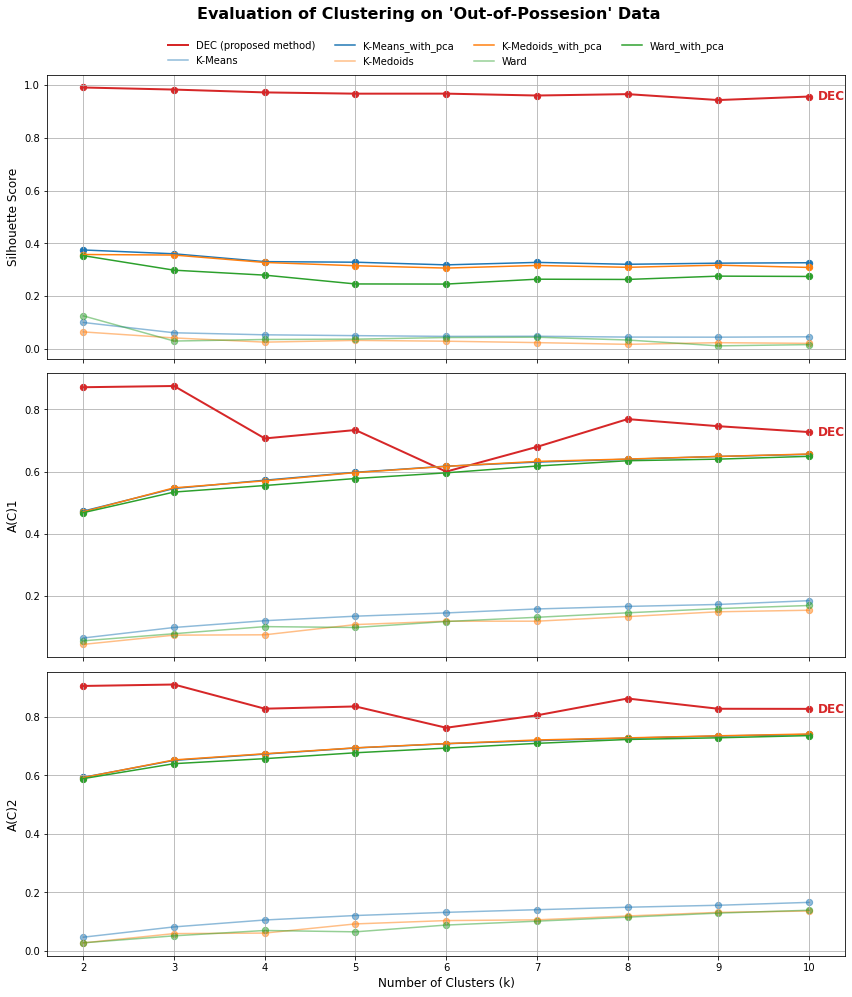

In [18]:
df = results_zscore_df.copy()

# Define mapping
old_methods = ['dec', 'kmeans', 'kmeans_pca', 'kmedoids', 'kmedoids_pca', 'ward', 'ward_pca']
new_methods = ['DEC (proposed method)', 'K-Means', 'K-Means_with_pca', 'K-Medoids', 'K-Medoids_with_pca', 'Ward', 'Ward_with_pca']
method_map = dict(zip(old_methods, new_methods))

# Apply mapping
df['method'] = df['method'].map(method_map)


# Ensure columns are correct and values are flattened
df['k'] = df['k'].astype(int)
df['silhouette_score'] = df['silhouette_score'].astype(float)
df['AC1'] = df['AC1'].astype(float)
df['AC2'] = df['AC2'].astype(float)

# Define method groups and colors
methods = ['DEC (proposed method)', 'K-Means', 'K-Means_with_pca', 'K-Medoids', 'K-Medoids_with_pca', 'Ward', 'Ward_with_pca']
base_colors = {
    'K-Means': '#1f77b4',
    'K-Medoids': '#ff7f0e',
    'Ward': '#2ca02c'
}
highlight_color = '#d62728'  # red for 'DEC (proposed method)'

# Color map with pale variants for base methods and shared colors
color_map = {
    'DEC (proposed method)': highlight_color,
    'K-Means': base_colors['K-Means'] + '80',
    'K-Means_with_pca': base_colors['K-Means'],
    'K-Medoids': base_colors['K-Medoids'] + '80',
    'K-Medoids_with_pca': base_colors['K-Medoids'],
    'Ward': base_colors['Ward'] + '80',
    'Ward_with_pca': base_colors['Ward']
}

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
metrics = ['silhouette_score', 'AC1', 'AC2']
ylabels = ['Silhouette Score', 'A(C)1', 'A(C)2']

for ax, metric, ylabel in zip(axs, metrics, ylabels):
    for method in methods:
        subset = df[df['method'] == method]
        x = subset['k'].to_numpy()
        y = subset[metric].to_numpy()
        ax.plot(x, y, label=method,
                color=color_map[method], linewidth=2 if method == 'DEC (proposed method)' else 1.5)
        ax.scatter(x, y, color=color_map[method], s=40)
        if method == 'DEC (proposed method)':
            ax.text(x[-1] + 0.1, y[-1], 'DEC', color=color_map[method],
                    fontsize=12, fontweight='bold', va='center')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True)

axs[-1].set_xlabel('Number of Clusters (k)', fontsize=12)
fig.suptitle("Evaluation of Clustering on 'Out-of-Possesion' Data", fontsize=16, fontweight='bold', y=.95)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=10, frameon=False)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()